In [3]:
# importing required libraries
import pandas as pd
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [4]:
# Generate synthetic transactional data
# Item pool
items_pool = ['milk', 'bread', 'beer', 'diapers', 'eggs', 'cheese',
              'butter', 'cereal', 'soda', 'apple', 'banana', 'chicken',
              'rice', 'pasta', 'coffee', 'tea', 'juice', 'cookies', 'chips', 'yogurt']

random.seed(42)  # reproducibility
transactions = []

In [5]:
# Create 40 transactions
for i in range(40):
    basket_size = random.randint(3, 6)
    basket = random.sample(items_pool, basket_size)
    transactions.append(basket)

In [6]:
# Add strong co-occurrence patterns
# 'milk' and 'bread' appear together in most baskets
for i in range(25):
    if 'milk' not in transactions[i]:
        transactions[i].append('milk')
    if 'bread' not in transactions[i]:
        transactions[i].append('bread')

# 'diapers' and 'beer' often appear together
for i in range(15, 30):
    if 'diapers' not in transactions[i]:
        transactions[i].append('diapers')
    if 'beer' not in transactions[i]:
        transactions[i].append('beer')

In [7]:

# Remove duplicates in each basket
transactions = [list(set(t)) for t in transactions]

In [8]:
# Convert to DataFrame using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)


In [9]:
print("Sample of transaction data:\n", df.head())

Sample of transaction data:
    apple  banana   beer  bread  butter  cereal  cheese  chicken  chips  \
0  False   False  False   True   False    True   False    False  False   
1  False   False   True   True   False   False   False    False  False   
2  False   False   True   True    True    True   False    False  False   
3  False   False  False   True    True   False   False    False  False   
4  False   False  False   True   False    True    True     True  False   

   coffee  cookies  diapers   eggs  juice  milk  pasta   rice   soda    tea  \
0   False    False    False  False  False  True  False  False   True  False   
1   False     True     True   True  False  True  False  False  False  False   
2   False    False    False  False  False  True  False  False   True  False   
3   False     True    False  False  False  True  False  False  False  False   
4    True    False    False  False  False  True  False  False   True  False   

   yogurt  
0   False  
1   False  
2   False  
3  

In [10]:
# Apply Apriori algorithm
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort rules by lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
print("\nTop 5 rules sorted by lift:\n", rules_sorted.head())


Top 5 rules sorted by lift:
          antecedents       consequents  antecedent support  \
54   (diapers, milk)     (beer, bread)               0.375   
51     (beer, bread)   (diapers, milk)               0.400   
52      (beer, milk)  (diapers, bread)               0.400   
53  (diapers, bread)      (beer, milk)               0.400   
43     (bread, soda)            (milk)               0.250   

    consequent support  support  confidence      lift  representativity  \
54               0.400    0.275    0.733333  1.833333               1.0   
51               0.375    0.275    0.687500  1.833333               1.0   
52               0.400    0.275    0.687500  1.718750               1.0   
53               0.400    0.275    0.687500  1.718750               1.0   
43               0.675    0.250    1.000000  1.481481               1.0   

    leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
54   0.12500        2.25       0.727273  0.55000   0.555556    0.710417 

In [11]:
# Analyze one top rule
if not rules_sorted.empty:
    top_rule = rules_sorted.iloc[0]
    print("\nAnalysis of top rule:")
    print(f"Rule: {top_rule['antecedents']} -> {top_rule['consequents']}")
    print(f"Support: {top_rule['support']:.2f}, Confidence: {top_rule['confidence']:.2f}, Lift: {top_rule['lift']:.2f}")
    print("Implication: Customers buying the antecedent items are highly likely to buy the consequent item. Retailers could use this for product placement or bundling strategies.")
else:
    print("No rules found with the given thresholds.")


Analysis of top rule:
Rule: frozenset({'diapers', 'milk'}) -> frozenset({'beer', 'bread'})
Support: 0.28, Confidence: 0.73, Lift: 1.83
Implication: Customers buying the antecedent items are highly likely to buy the consequent item. Retailers could use this for product placement or bundling strategies.


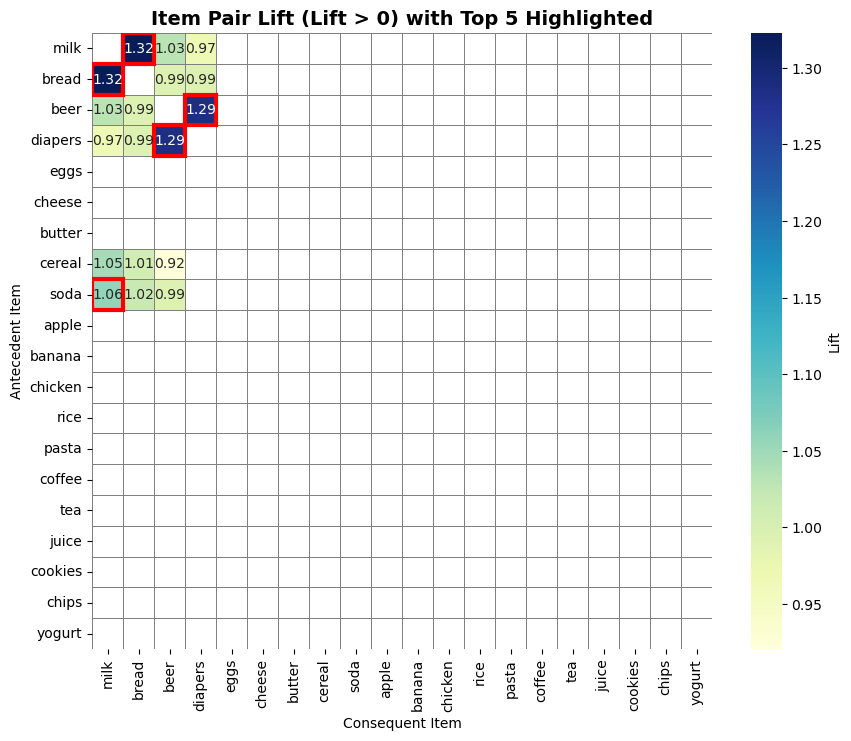

In [14]:
# Heatmap of Positive Lift with Top 5 Highlighted


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter to rules with exactly 1 item in antecedent & consequent
pair_rules = rules_sorted[(rules_sorted['antecedents'].apply(lambda x: len(x) == 1)) &
                          (rules_sorted['consequents'].apply(lambda x: len(x) == 1))]

# Create DataFrame for heatmap, initialize with NaN
heatmap_data = pd.DataFrame(index=items_pool, columns=items_pool, data=np.nan)

# Populate lift values for lift > 0
for _, row in pair_rules.iterrows():
    item_a = list(row['antecedents'])[0]
    item_b = list(row['consequents'])[0]
    if row['lift'] > 0:
        heatmap_data.loc[item_a, item_b] = row['lift']

# Identify top 5 strongest lift values
top5_lifts = pair_rules.nlargest(5, 'lift')

# Create a mask for highlighting top 5
highlight_mask = pd.DataFrame(False, index=items_pool, columns=items_pool)
for _, row in top5_lifts.iterrows():
    item_a = list(row['antecedents'])[0]
    item_b = list(row['consequents'])[0]
    highlight_mask.loc[item_a, item_b] = True

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Lift'}, linewidths=0.5, linecolor='gray')

# Highlight top 5 strongest lifts with red boxes
for i in range(len(items_pool)):
    for j in range(len(items_pool)):
        if highlight_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))

plt.title("Item Pair Lift (Lift > 0) with Top 5 Highlighted", fontsize=14, fontweight="bold")
plt.xlabel("Consequent Item")
plt.ylabel("Antecedent Item")
plt.show()
